In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm,invgauss

from scipy.stats import norm
from scipy.optimize import fsolve
from math import pi, erf, exp, log
import plotly.express as px

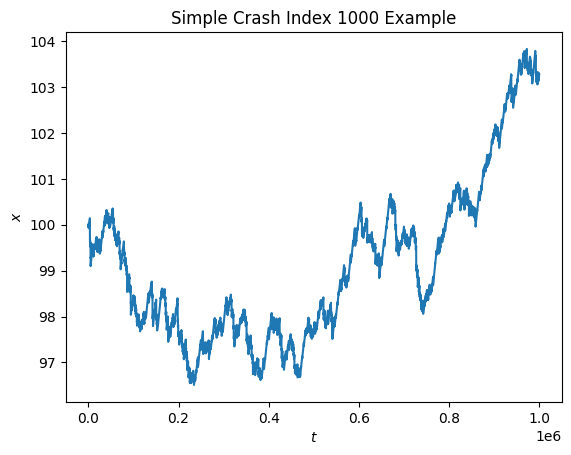

In [2]:
n = 1000000
dt = 1/(365*24*60*60)
x0 = 100
sigma = 1
mean = 1

np.random.seed(1)
MUT= 0.00561999
MDT = -5.619
up_prob = 0.001


# MUT = np.log((1-up_prob*np.exp(MDT))/(1-up_prob))

random = np.random.uniform(size=(n))
direction =  np.where(random>up_prob,MUT,MDT)
random = np.random.normal(mean,sigma, size=(n))

miu = sigma * np.sqrt(2/np.pi)*np.exp(-mean**2/2/sigma**2)+ mean*(1-2*norm.cdf(-mean/sigma))

x = np.exp(direction * abs(random)/miu* np.sqrt(dt))
x = x0 * x.cumprod(axis=0)

plt.plot(x)
# plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Simple Crash Index 1000 Example"
)
plt.show()

In [3]:
# Crash: requires probability of crash and relative difference of crashed price w.r.t previous spot
# Returns hash of MDT and MUT and formula MUT and error
def crash_get_mean_jumps(p_down = 0.001, diff_percent = 0.001, MDT=0):
    # Parameters
    p_up = 1 - p_down
    mu = 1
    sigma = 1
    dt = 1/np.sqrt(365*86400)
    
    # Mean of folded normal with parameters mu & sigma
    mu_Y = sigma*np.sqrt(2/pi)*exp(-mu**2/(2*sigma**2)) + mu * erf(mu/np.sqrt(2*sigma**2))

    # MDT can be calculated using diff_percent only (Needs review & verification)
    if MDT ==0: MDT = log(1-diff_percent)/dt
    
    # Solve using t2 to get t1 to ensure E(St/S{t-1}) = 1
    t2 = MDT*dt/mu_Y
    factor = lambda t: np.exp(t**2 / 2 + t) * norm.cdf(1+t) + np.exp(t**2 / 2 - t) * norm.cdf(t-1)
    
    f = lambda x: 1 - p_down*factor(t2) - p_up*factor(x)
    z = fsolve(f,0)[0]

    # Final result
    MUT = z/dt*mu_Y
    # Given formula
    formula_MUT = -MDT*p_down/p_up
    return {'MDT': MDT,
            'MUT': MUT,
            'formula_MUT': formula_MUT,
            'err': abs(MUT-formula_MUT)}

# Boom: requires probability of boom and relative difference of boom price w.r.t previous spot
# Returns hash of MUT and MDT and formula MDT and error
def boom_get_mean_jumps(p_up = 0.001, diff_percent = 0.00, MUT=0):
    # Parameters
    p_down = 1 - p_up
    mu = 1
    sigma = 1
    dt = 1/np.sqrt(365*86400)
    
    # Mean of folded normal with parameters mu & sigma
    mu_Y = sigma*np.sqrt(2/pi)*exp(-mu**2/(2*sigma**2)) + mu * erf(mu/np.sqrt(2*sigma**2))

    # MUT can be calculated using diff_percent only (Needs review & verification)
    if MUT == 0: MUT = log(1+diff_percent)/dt
    
    # Solve using t2 to get t1 to ensure E(St/S{t-1}) = 1
    t1 = MUT*dt/mu_Y
    factor = lambda t: np.exp(t**2 / 2 + t) * norm.cdf(1+t) + np.exp(t**2 / 2 - t) * norm.cdf(t-1)
    f = lambda x: 1 - p_up*factor(t1) - p_down*factor(x)
    z = fsolve(f,-0)[0]
    
    # Final result
    MDT = z/dt*mu_Y
    # Given formula
    formula_MDT = -MUT*p_up/p_down
    return {'MUT': MUT, 
            'MDT': MDT,
            'formula_MDT': formula_MDT,
            'err': abs(MDT-formula_MDT)}

In [4]:
crash_1000 = crash_get_mean_jumps(p_down=1/1000,MDT=-5.619)
crash_500 = crash_get_mean_jumps(p_down=1/500,MDT=-5.619)
crash_300 = crash_get_mean_jumps(p_down=1/300,diff_percent=0.0026)

boom_1000 = boom_get_mean_jumps(p_up=1/1000,MUT=5.619)
boom_500 = boom_get_mean_jumps(p_up=1/500,MUT=5.619)
boom_300 = boom_get_mean_jumps(p_up=1/300,diff_percent=0.0026)

df = pd.DataFrame.from_dict([crash_1000, crash_500,crash_300,boom_1000,boom_500,boom_300])
df.index = ['Crash 1000', 'Crash 500','Crash 300','Boom 1000','Boom 500','Boom 300']

In [5]:
def cb_vol_sim(up_prob,MUT,MDT):

    n = 1000000
    dt = 1/(365*24*60*60)
    x0 = 100
    sigma = 1
    mean = 1

    np.random.seed(1)
    MUT = MUT
    MDT = MDT
    up_prob = up_prob

    random = np.random.uniform(size=(n))
    direction =  np.where(random>up_prob,MUT,MDT)
    random = np.random.normal(mean,sigma, size=(n))

    miu = sigma * np.sqrt(2/np.pi)*np.exp(-mean**2/2/sigma**2)+ mean*(1-2*norm.cdf(-mean/sigma))

    x = np.exp(direction * abs(random)/miu* np.sqrt(dt))
    x = x0 * x.cumprod(axis=0)
    df_x = pd.DataFrame(x)
    df_x['return'] = np.log(df_x[0]/df_x[0].shift(1))
    
    return df_x['return'].std()/np.sqrt(dt)

In [6]:
df['volatility'] = 0
for i in range(len(df)):
    if df.index[i].split(sep=" ")[0] == "Crash":
        up_prob = 1/int(df.index[i].split(sep=" ")[1])
    else:
        up_prob = 1-1/int(df.index[i].split(sep=" ")[1])

    vol = cb_vol_sim(up_prob=up_prob,MUT= df['MUT'][i],MDT=df['MDT'][i])
    df.iloc[i,-1]= vol
    # print(vol)
df

,MDT,MUT,formula_MUT,err,formula_MDT,volatility
Crash 1000,-5.619000,0.005620,0.005625,0.000004,NaN,0.210626
Crash 500,-5.619000,0.011252,0.011261,0.000008,NaN,0.297229
Crash 300,-14.619814,0.048802,0.048896,0.000094,NaN,1.031343
Boom 1000,-0.005629,5.619000,NaN,0.000004,-0.005625,0.211554
Boom 500,-0.011269,5.619000,NaN,0.000008,-0.011261,0.302883
Boom 300,-0.048862,14.581852,NaN,0.000093,-0.048769,1.007243
